In [46]:
from datetime import date
import numpy as np
import os
import pandas as pd
import time

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from io import StringIO

# Settings

In [2]:
dataDir = "./P1_Foodmart"
transaction_filename = "FoodMart-Transactions-1998.csv"
product_filename = "Product-Lookup.csv"
customer_filename = "Customer-Lookup.csv"

# Input

In [3]:
# input: transactions
df_trans = pd.read_csv(os.path.join(dataDir,transaction_filename))

In [4]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity
0,1/1/1998,12/25/1997,4,2439,10,3
1,1/1/1998,12/28/1997,11,4284,10,3
2,1/1/1998,12/28/1997,12,534,10,3
3,1/1/1998,12/29/1997,14,9743,10,2
4,1/1/1998,12/27/1997,16,3608,10,3


In [5]:
# input: products
df_prod = pd.read_csv(os.path.join(dataDir,product_filename))

In [6]:
df_prod.head()

,product_id,product_brand,product_name,product_sku,product_retail_price,product_cost,product_weight,recyclable,low_fat
0,1,Washington,Washington Berry Juice,90748583674,2.85,0.94,8.39,NaN,NaN
1,2,Washington,Washington Mango Drink,96516502499,0.74,0.26,7.42,NaN,1.0
2,3,Washington,Washington Strawberry Drink,58427771925,0.83,0.40,13.10,1.0,1.0
3,4,Washington,Washington Cream Soda,64412155747,3.64,1.64,10.60,1.0,NaN
4,5,Washington,Washington Diet Soda,85561191439,2.19,0.77,6.66,1.0,NaN


# Data Preprocessing

## RFM: monetary

In [7]:
# look up the price of the product by its product_id
def lookup_price(product_id, df=df_prod):
    return df_prod[df_prod["product_id"]==product_id]["product_retail_price"].values[0]

In [8]:
df_trans["price"] = [lookup_price(pid) for pid in df_trans["product_id"]]

In [9]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price
0,1/1/1998,12/25/1997,4,2439,10,3,3.64
1,1/1/1998,12/28/1997,11,4284,10,3,3.51
2,1/1/1998,12/28/1997,12,534,10,3,1.54
3,1/1/1998,12/29/1997,14,9743,10,2,1.93
4,1/1/1998,12/27/1997,16,3608,10,3,3.83


In [10]:
df_trans["amount"] = df_trans["quantity"]*df_trans["price"]

In [11]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price,amount
0,1/1/1998,12/25/1997,4,2439,10,3,3.64,10.92
1,1/1/1998,12/28/1997,11,4284,10,3,3.51,10.53
2,1/1/1998,12/28/1997,12,534,10,3,1.54,4.62
3,1/1/1998,12/29/1997,14,9743,10,2,1.93,3.86
4,1/1/1998,12/27/1997,16,3608,10,3,3.83,11.49


In [12]:
m_value_tmp = df_trans.groupby(["customer_id","transaction_date"])['amount'].apply(sum)
m_value_tmp

C:\Users\Henry\AppData\Local\Temp\ipykernel_20896\3333363460.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  m_value_tmp = df_trans.groupby(["customer_id","transaction_date"])['amount'].apply(sum)


customer_id  transaction_date
3            3/29/1998           67.15
             4/17/1998           37.48
6            1/16/1998            6.52
             12/16/1998          34.97
             6/25/1998           40.46
                                 ...  
10280        8/23/1998           41.13
10281        1/7/1998            49.49
             6/23/1998           66.36
             7/17/1998           88.85
             8/1/1998            42.20
Name: amount, Length: 37786, dtype: float64

C:\Users\Henry\AppData\Local\Temp\ipykernel_20896\1300281508.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  m_value = df_trans.groupby(["customer_id"])['amount'].apply(sum)


<Axes: >

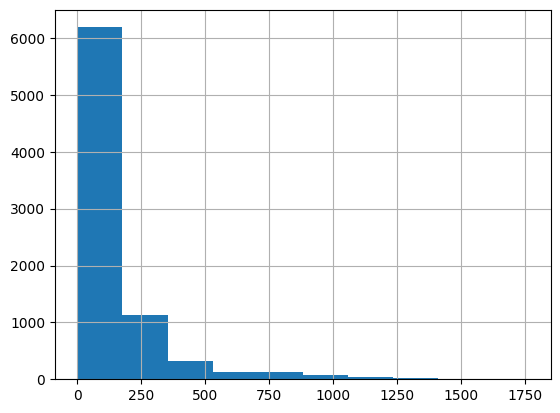

In [13]:
m_value = df_trans.groupby(["customer_id"])['amount'].apply(sum)
m_value.hist()

## RFM: recency

In [14]:
df_trans["trans_days"] = [(date(int(d.split("/")[2]),int(d.split("/")[0]),int(d.split("/")[1]))-date(1998,12,31)).days for d in df_trans["transaction_date"]]
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price,amount,trans_days
0,1/1/1998,12/25/1997,4,2439,10,3,3.64,10.92,-364
1,1/1/1998,12/28/1997,11,4284,10,3,3.51,10.53,-364
2,1/1/1998,12/28/1997,12,534,10,3,1.54,4.62,-364
3,1/1/1998,12/29/1997,14,9743,10,2,1.93,3.86,-364
4,1/1/1998,12/27/1997,16,3608,10,3,3.83,11.49,-364


In [15]:
r_trans_tmp = df_trans.groupby("customer_id")['trans_days'].unique()
r_trans_tmp

customer_id
3                                             [-277, -258]
6                                        [-349, -189, -15]
8        [-304, -260, -211, -188, -167, -112, -97, -90,...
9                                              [-248, -83]
10                            [-348, -308, -263, -201, -8]
                               ...                        
10275                             [-309, -238, -228, -179]
10277                               [-280, -100, -74, -58]
10278                             [-307, -288, -282, -247]
10280             [-315, -263, -207, -206, -130, -56, -23]
10281                             [-358, -191, -167, -152]
Name: trans_days, Length: 8060, dtype: object

<Axes: >

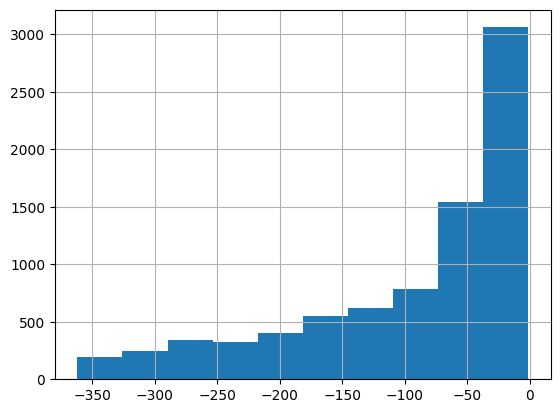

In [16]:
r_value = df_trans.groupby("customer_id")['trans_days'].max()
r_value.hist()

## RFM: frequency

<Axes: >

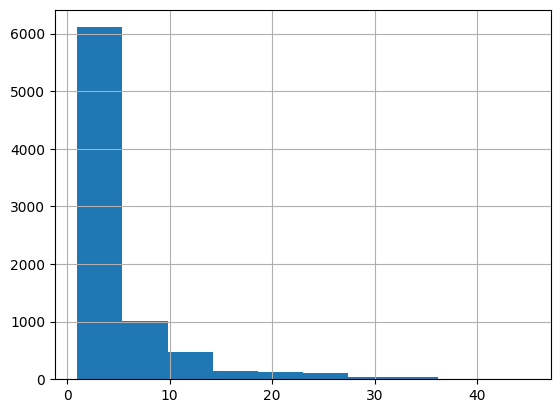

In [17]:
f_value = df_trans.groupby(["customer_id"])["transaction_date"].nunique()
f_value.hist()

In [18]:
r_min = r_value.min()
r_max = r_value.max()
f_min = f_value.min()
f_max = f_value.max()
m_min = m_value.min()
m_max = m_value.max()

rfm_summary = pd.DataFrame({
    'Metric': ['Recency (R)', 'Frequency (F)', 'Monetary (M)'],
    'Min': [r_min, f_min, m_min],
    'Max': [r_max, f_max, m_max]
})

# 顯示表格
print(rfm_summary)

          Metric     Min      Max
0    Recency (R) -362.00    -1.00
1  Frequency (F)    1.00    45.00
2   Monetary (M)    1.06  1763.58


# Observation: RFM 

In [19]:
df_user = pd.concat([f_value, m_value, r_value], axis=1)
df_user.columns = ["f","m","r"]

In [20]:
df_user.head()

,f,m,r
customer_id,,,
3,2,104.63,-258
6,3,81.95,-15
8,10,259.14,-34
9,2,89.58,-83
10,5,147.25,-8


### 第二題

<Axes: xlabel='r', ylabel='f'>

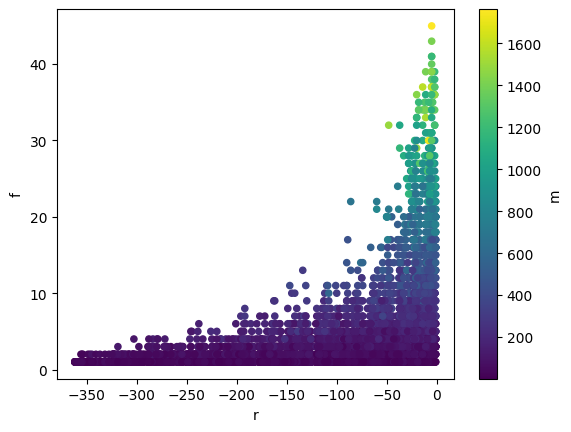

In [21]:
df_user.plot.scatter(y="f", x="r", c="m", colormap='viridis')

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='r', ylabel='f'>

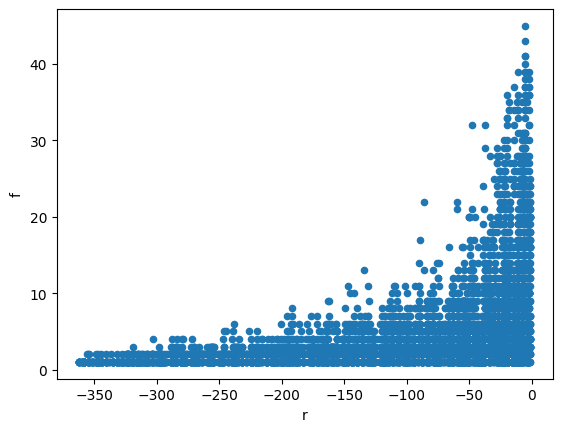

In [22]:
# RF 二維散布圖
df_user.plot.scatter(x="r", y="f", colormap='viridis')

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='r', ylabel='m'>

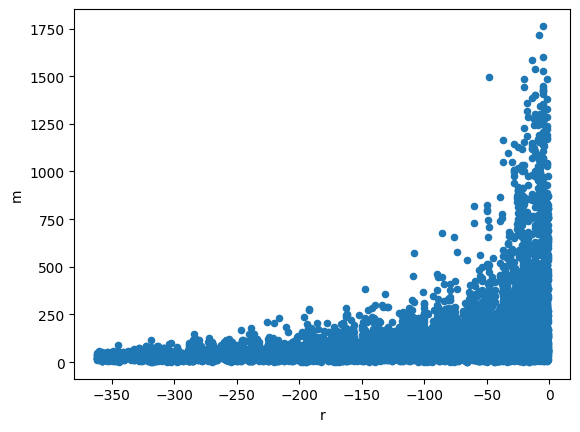

In [23]:
# RM 二維散布圖
df_user.plot.scatter(x="r", y="m", colormap='viridis')

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='f', ylabel='m'>

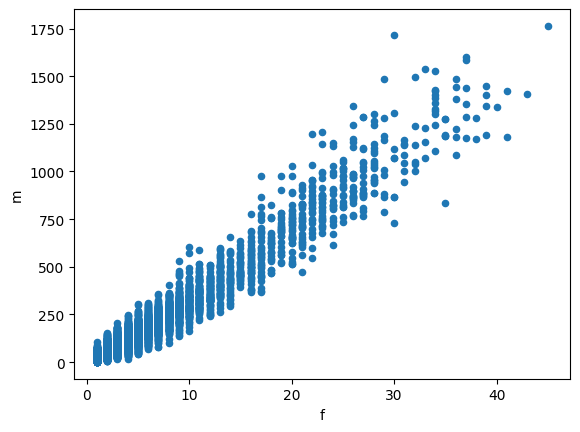

In [24]:
# FM 二維散布圖
df_user.plot.scatter(x="f", y="m", colormap='viridis')

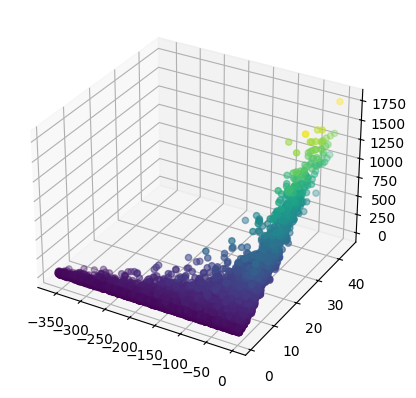

In [25]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');

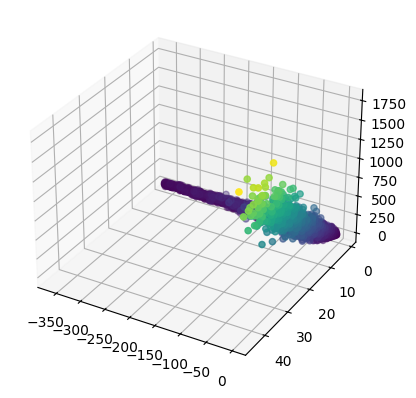

In [26]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');
ax.invert_yaxis()

ax.view_init(elev, azim)：設定 3D 圖表的仰角 (elevation) 和方位角 (azimuth)，從而改變視角。

elev：仰角(elevation)，表示從 XY 平面向上或向下看的角度。

azim：方位角(azimuth)，表示在 XY 平面中旋轉的角度。

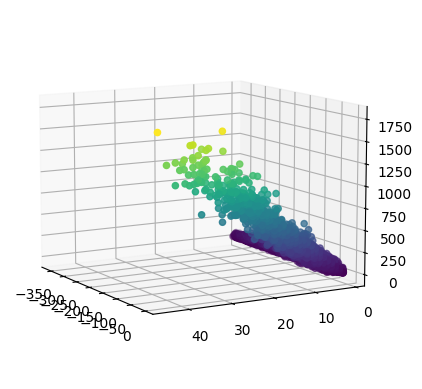

In [27]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');
ax.invert_yaxis()
ax.view_init(elev=10,azim=-30)

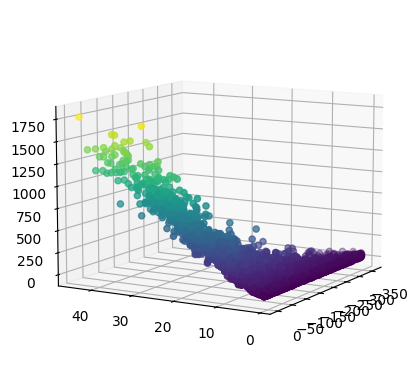

In [28]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');
ax.invert_yaxis()
ax.view_init(elev=10,azim=30)

### 第三題

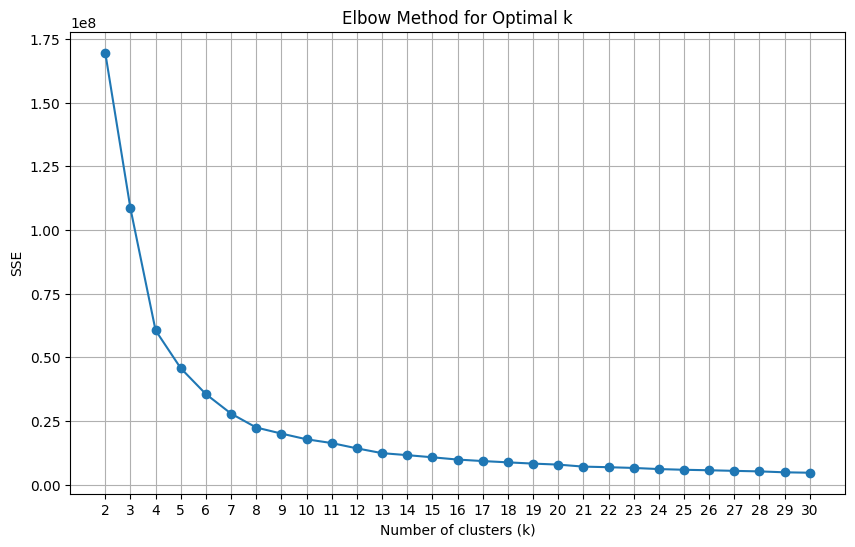

In [29]:
rfm_data = df_user[["f", "m", "r"]]

sse = []

for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_data)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(2, 31), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.xticks(range(2, 31))
plt.grid()
plt.show()

### 第四題

In [31]:
kmeans_best = KMeans(n_clusters=4, random_state=42)
kmeans_best.fit(rfm_data)

# 抓出中心點並排序
centroids = pd.DataFrame(kmeans_best.cluster_centers_, columns=['F', 'M', 'R'])
centroids_sorted = centroids.sort_values(by='M', ascending=False)
print(centroids_sorted)

           F           M           R
1  25.288820  940.794907  -12.770186
3  10.424670  344.674714  -28.936564
0   3.211346   91.545168  -53.590434
2   1.601518   44.435968 -230.483397


### 第五題

In [37]:
# Fit the KMeans model
kmeans_best = KMeans(n_clusters=4, random_state=42)
kmeans_best.fit(rfm_data)

# Add the cluster labels to df_user
df_user['Cluster'] = kmeans_best.labels_

# Now you can proceed with your analysis
group1_count = df_user[df_user['Cluster'] == 1].shape[0]
print(f"Group 1 count: {group1_count}")

print(f"--------------------")
group0_count = df_user[df_user['Cluster'] == 0].shape[0]
group2_count = df_user[df_user['Cluster'] == 2].shape[0]
group3_count = df_user[df_user['Cluster'] == 3].shape[0]
print(f"Group 0 count: {group0_count}")
print(f"Group 1 count: {group1_count}")
print(f"Group 2 count: {group2_count}")
print(f"Group 3 count: {group3_count}")

Group 1 count: 322
--------------------
Group 0 count: 4495
Group 1 count: 322
Group 2 count: 2104
Group 3 count: 1139


In [41]:
# Fit the KMeans model
kmeans_best = KMeans(n_clusters=4, random_state=42)
kmeans_best.fit(rfm_data)

# Add the cluster labels to df_user
df_user['Cluster'] = kmeans_best.labels_

group1 = df_user[df_user['Cluster'] == 1]
print("R range:", [group1['r'].min(), group1['r'].max()])
print("F range:", [group1['f'].min(), group1['f'].max()])
print("M range:", [group1['m'].min(), group1['m'].max()])

R range: [-86, -1]
F range: [14, 45]
M range: [643.8000000000001, 1763.58]


In [59]:
# 讀取資料
# input: transactions
df_trans = pd.read_csv(os.path.join(dataDir,transaction_filename))
df_prod = pd.read_csv(os.path.join(dataDir,product_filename))
df_customers = pd.read_csv(os.path.join(dataDir,customer_filename))
df_user['Cluster'] = kmeans_best.labels_

# 合併資料
df_merged = pd.merge(df_trans, df_prod, on='product_id', how='left')
df_merged = pd.merge(df_merged, df_customers, on='customer_id', how='left')
df_merged = pd.merge(df_merged, df_user, on='customer_id', how='left')

# 提取 cluster1
cluster1 = df_merged[df_merged['Cluster'] == 1]

In [60]:
# 分析交易層面
print("=== Cluster 1 產品偏好 ===")
product_counts = cluster1['product_name'].value_counts()
print(product_counts)

=== Cluster 1 產品偏好 ===
product_name
High Top New Potatos          48
Nationeel Fudge Brownies      47
Super Chunky Peanut Butter    46
Better Noodle Soup            45
Moms Roasted Chicken          45
                              ..
Plato Sesame Oil              15
Colony White Bread            14
Washington Diet Soda          14
Washington Berry Juice        12
CDR Apple Preserves            9
Name: count, Length: 1559, dtype: int64
